## Load train data

In [1]:
import convenience
df_normal_train_val, sample_rates = convenience.load_train()
file_names = df_normal_train_val.file_name
print(df_normal_train_val.head())
file_names.head()

     file_name stratify accent gender  \
0  1f_1018.wav       1f      1      f   
1  1f_1026.wav       1f      1      f   
2  1f_1031.wav       1f      1      f   
3  1f_1070.wav       1f      1      f   
4  1f_1075.wav       1f      1      f   

                                               audio    length  
0  [tensor(-0.0002), tensor(-6.1035e-05), tensor(...  3.413312  
1  [tensor(-0.0008), tensor(-0.0008), tensor(-0.0...  5.632000  
2  [tensor(-0.0002), tensor(-0.0002), tensor(-0.0...  4.693313  
3  [tensor(0.0022), tensor(0.0019), tensor(0.0018...  3.925312  
4  [tensor(0.), tensor(3.0518e-05), tensor(0.), t...  2.737500  


0    1f_1018.wav
1    1f_1026.wav
2    1f_1031.wav
3    1f_1070.wav
4    1f_1075.wav
Name: file_name, dtype: object

In [ ]:
df_augment_train_val, sample_rates = convenience.load_train("augmented")
df_augment_train_val.head()

In [ ]:
len(df_augment_train_val) + len(df_normal_train_val)

9498

### Combine augmented and non-augmented data togehter

In [ ]:
import pandas as pd
df_train_val = pd.concat([df_augment_train_val, df_normal_train_val], axis = 0, ignore_index=True)

In [ ]:
display(df_train_val)

,file_name,stratify,accent,gender,audio,length
0,1f_1018_0.wav,1f,1,f,"[tensor(-0.0008), tensor(0.0015), tensor(0.003...",3.413312
1,1f_1018_3166.wav,1f,1,f,"[tensor(-0.0005), tensor(0.0002), tensor(-9.15...",3.413312
2,1f_1026_1.wav,1f,1,f,"[tensor(-0.0023), tensor(0.0012), tensor(-0.00...",5.632000
3,1f_1026_3167.wav,1f,1,f,"[tensor(-0.0007), tensor(-0.0008), tensor(-0.0...",5.632000
4,1f_1031_2.wav,1f,1,f,"[tensor(0.), tensor(9.1553e-05), tensor(0.0003...",4.693313
...,...,...,...,...,...,...
9493,5m_9719.wav,5m,5,m,"[tensor(0.0002), tensor(3.0518e-05), tensor(0....",5.461313
9494,5m_9742.wav,5m,5,m,"[tensor(0.0003), tensor(0.0002), tensor(0.0004...",3.310125
9495,5m_9771.wav,5m,5,m,"[tensor(0.0003), tensor(0.0002), tensor(0.0004...",2.592563
9496,5m_9778.wav,5m,5,m,"[tensor(0.), tensor(0.), tensor(0.), tensor(0....",3.065000


## Trim silence

In [ ]:
#silence cutting
import librosa 
trimmed_audio = []

for file in df_train_val.audio:
    trimmed, index = librosa.effects.trim(file, top_db = 40)    
    trimmed_audio.append(trimmed)
    
df_train_val.audio = trimmed_audio
#df_train_val["trimmed"] = trimmed_audio

In [ ]:
# df_train_val["trimmed"] = trimmed_audio
from IPython.display import Audio
Audio(df_train_val.audio[9497],rate = 16000)
#df_train_val.audio[3164]

In [ ]:
df_train_val["length"] = [len(df_train_val.audio[i])/16000 for i  in range(0, len(df_train_val.audio))]

In [ ]:
import IPython.display as ipd
display(df_train_val)
display(ipd.Audio(df_train_val.audio[0], rate=16000))
display(ipd.Audio(trimmed_audio[0], rate=16000))

,file_name,stratify,accent,gender,audio,length,trimmed
0,1f_1018_0.wav,1f,1,f,"[tensor(-0.0008), tensor(0.0015), tensor(0.003...",3.413312,"[tensor(-0.0008), tensor(0.0015), tensor(0.003..."
1,1f_1018_3166.wav,1f,1,f,"[tensor(0.0019), tensor(0.0005), tensor(-0.000...",2.432000,"[tensor(0.0019), tensor(0.0005), tensor(-0.000..."
2,1f_1026_1.wav,1f,1,f,"[tensor(-0.0002), tensor(-6.1035e-05), tensor(...",5.600000,"[tensor(-0.0002), tensor(-6.1035e-05), tensor(..."
3,1f_1026_3167.wav,1f,1,f,"[tensor(-0.0003), tensor(-0.0005), tensor(-0.0...",4.320000,"[tensor(-0.0003), tensor(-0.0005), tensor(-0.0..."
4,1f_1031_2.wav,1f,1,f,"[tensor(-0.0006), tensor(-9.1553e-05), tensor(...",2.240000,"[tensor(-0.0006), tensor(-9.1553e-05), tensor(..."
...,...,...,...,...,...,...,...
9493,5m_9719.wav,5m,5,m,"[tensor(-0.0002), tensor(-0.0002), tensor(-0.0...",2.144000,"[tensor(-0.0002), tensor(-0.0002), tensor(-0.0..."
9494,5m_9742.wav,5m,5,m,"[tensor(0.), tensor(-3.0518e-05), tensor(-3.05...",2.496000,"[tensor(0.), tensor(-3.0518e-05), tensor(-3.05..."
9495,5m_9771.wav,5m,5,m,"[tensor(0.), tensor(0.), tensor(0.), tensor(6....",1.856000,"[tensor(0.), tensor(0.), tensor(0.), tensor(6...."
9496,5m_9778.wav,5m,5,m,"[tensor(6.1035e-05), tensor(-3.0518e-05), tens...",1.792000,"[tensor(6.1035e-05), tensor(-3.0518e-05), tens..."


## Loop data

In [ ]:
import math

target_duration = math.ceil(df_train_val.length.max())
sr = list(sample_rates)[0]

df_train_val, _ = convenience.loop_audio_df(df_train_val, target_duration, sr)
df_train_val.head()

MemoryError: Unable to allocate 1.59 MiB for an array with shape (208000,) and data type object

## Normalize data

In [ ]:
import torch
df_train_val['audio_norm'] = df_train_val.looped_audio/[torch.max(torch.abs(df_train_val.looped_audio[i])) for i in range(len(df_train_val.looped_audio))]
df_train_val.head()

,file_name,stratify,accent,gender,audio,length,looped_audio,looped_length,audio_norm
0,1f_1018.wav,1f,1,f,"[tensor(3.0518e-05), tensor(0.0002), tensor(0....",2.336,"[tensor(3.0518e-05), tensor(0.0002), tensor(0....",13.0,"[tensor(6.7967e-05), tensor(0.0005), tensor(0...."
1,1f_1026.wav,1f,1,f,"[tensor(0.0003), tensor(0.0003), tensor(0.0002...",4.256,"[tensor(0.0003), tensor(0.0003), tensor(0.0002...",13.0,"[tensor(0.0004), tensor(0.0004), tensor(0.0003..."
2,1f_1031.wav,1f,1,f,"[tensor(0.0002), tensor(9.1553e-05), tensor(9....",2.112,"[tensor(0.0002), tensor(9.1553e-05), tensor(9....",13.0,"[tensor(0.0003), tensor(0.0002), tensor(0.0002..."
3,1f_1070.wav,1f,1,f,"[tensor(-0.0005), tensor(-0.0008), tensor(-0.0...",1.408,"[tensor(-0.0005), tensor(-0.0008), tensor(-0.0...",13.0,"[tensor(-0.0010), tensor(-0.0015), tensor(-0.0..."
4,1f_1075.wav,1f,1,f,"[tensor(0.), tensor(0.), tensor(0.), tensor(0....",1.856,"[tensor(0.), tensor(0.), tensor(0.), tensor(0....",13.0,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."


In [ ]:
maxs = [torch.max(torch.abs(df_train_val.audio_norm[i])) for i in range(len(df_train_val.audio_norm))]
mins = [torch.min(torch.abs(df_train_val.audio_norm[i])) for i in range(len(df_train_val.audio_norm))]
means = [torch.sum(torch.abs(df_train_val.audio_norm[i]))/len(df_train_val.audio_norm[i]) for i in range(len(df_train_val.audio_norm))]

print("Maximums")
print("min:\t",min(maxs))
print("max:\t",max(maxs))
print("mean:\t",sum(maxs)/len(maxs))

print("\nMinimums")
print("min:\t",min(mins))
print("max:\t",max(mins))
print("mean:\t",sum(mins)/len(mins))

print("\nMeans")
print("min:\t",min(means))
print("max:\t",max(means))
print("mean:\t",sum(means)/len(means))


Maximums
min:	 tensor(1.)
max:	 tensor(1.)
mean:	 tensor(1.)

Minimums
min:	 tensor(0.)
max:	 tensor(0.)
mean:	 tensor(0.)

Means
min:	 tensor(0.0201)
max:	 tensor(0.2353)
mean:	 tensor(0.0914)


## Split data

In [9]:
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(df_train_val, test_size=0.2, random_state=42, stratify=df_train_val.stratify)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

Text(0, 0.5, 'Number of samples')

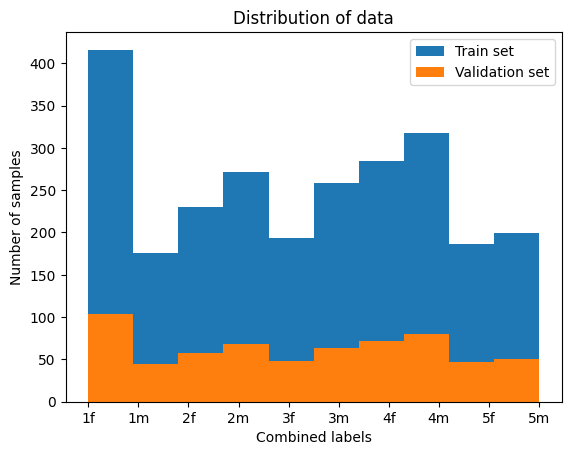

In [10]:
import matplotlib.pyplot as plt

plt.title("Distribution of data")
plt.hist(df_train.sort_values('stratify').stratify)
plt.hist(df_val.sort_values('stratify').stratify)
plt.legend(("Train set", "Validation set"))
plt.xlabel("Combined labels")
plt.ylabel("Number of samples")

## Turn audio into spectrograms

In [11]:
display(df_train.head())

,file_name,stratify,accent,gender,audio,length,looped_audio,looped_length,audio_norm
0,1f_6804.wav,1f,1,f,"[tensor(3.0518e-05), tensor(0.), tensor(3.0518...",2.144000,"[tensor(3.0518e-05), tensor(0.), tensor(3.0518...",13.0,"[tensor(6.6961e-05), tensor(0.), tensor(6.6961..."
1,5m_8397.wav,5m,5,m,"[tensor(-3.0518e-05), tensor(-3.0518e-05), ten...",3.264000,"[tensor(-3.0518e-05), tensor(-3.0518e-05), ten...",13.0,"[tensor(-3.9667e-05), tensor(-3.9667e-05), ten..."
2,1f_4170.wav,1f,1,f,"[tensor(-6.1035e-05), tensor(-0.0001), tensor(...",3.776000,"[tensor(-6.1035e-05), tensor(-0.0001), tensor(...",13.0,"[tensor(-0.0001), tensor(-0.0002), tensor(-0.0..."
3,3f_7513.wav,3f,3,f,"[tensor(-6.1035e-05), tensor(-0.0001), tensor(...",5.663938,"[tensor(-6.1035e-05), tensor(-0.0001), tensor(...",13.0,"[tensor(-0.0001), tensor(-0.0003), tensor(-0.0..."
4,4m_2278.wav,4m,4,m,"[tensor(-0.0002), tensor(-0.0002), tensor(-9.1...",5.152000,"[tensor(-0.0002), tensor(-0.0002), tensor(-9.1...",13.0,"[tensor(-0.0003), tensor(-0.0002), tensor(-0.0..."


In [12]:
import librosa
import numpy as np
import os

if (not os.path.isdir("preprocessed")): os.mkdir("preprocessed")
if (not os.path.isdir("preprocessed/train")): os.mkdir("preprocessed/train")
if (not os.path.isdir("preprocessed/train/specs")): os.mkdir("preprocessed/train/specs")
if (not os.path.isdir("preprocessed/val")): os.mkdir("preprocessed/val")
if (not os.path.isdir("preprocessed/val/specs")): os.mkdir("preprocessed/val/specs")

labels_csv_out = ""

for i in range(len(df_train.looped_audio)):
    S = librosa.feature.melspectrogram(y=df_train.looped_audio[i].numpy(), sr=16000)
    labels_csv_out += ",".join([f"{df_train.file_name[i][:-4]}.npy", str(df_train.accent[i]),"\n"])
    np.save(f'preprocessed/train/specs/{df_train.file_name[i][:-4]}.npy', S)

with open("preprocessed/train/labels.csv", "w+") as f:
    f.write(labels_csv_out)

labels_csv_out = ""

for i in range(len(df_val.looped_audio)):
    S = librosa.feature.melspectrogram(y=df_val.looped_audio[i].numpy(), sr=16000)
    labels_csv_out += ",".join([f"{df_val.file_name[i][:-4]}.npy", str(df_val.accent[i]), "\n"])
    np.save(f'preprocessed/val/specs/{df_val.file_name[i][:-4]}.npy', S)


with open("preprocessed/val/labels.csv", "w+") as f:
    f.write(labels_csv_out)

In [13]:
librosa.feature.melspectrogram(y=df_train_val.looped_audio[0].numpy(), sr=16000).shape

(128, 407)

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

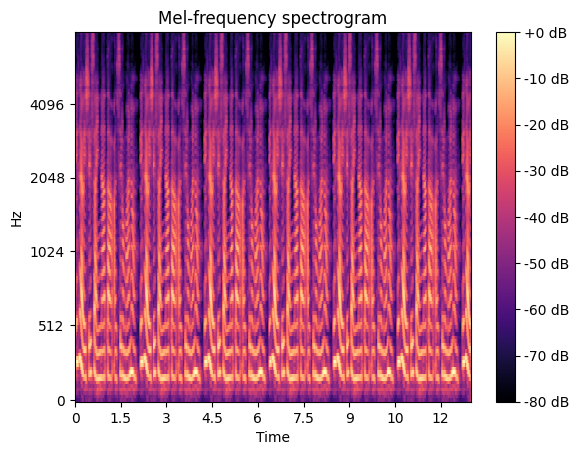

In [14]:
# # Sanity check
import matplotlib.pyplot as plt
import os
S = np.load(f"preprocessed/train/specs/{os.listdir('preprocessed/train/specs')[1]}")
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=16000, ax=ax)

fig.colorbar(img, ax=ax, format='%+2.0f dB')

ax.set(title='Mel-frequency spectrogram')

## Process test data

In [15]:
# Pre-process test set
import convenience
import torch
df_test, sample_rates = convenience.load_test()
display(df_test.head())

target_duration = 13
sr = 16000

df_test, _ = convenience.loop_audio_df(df_test, target_duration=target_duration, sr=sr)
display(df_test.head())

df_test['audio_norm'] = df_test.looped_audio/[torch.max(torch.abs(df_test.looped_audio[i])) for i in range(len(df_test.looped_audio))]
display(df_test.head())


,id,file_name,audio,length
0,1035,1035.wav,"[tensor(6.1035e-05), tensor(0.0003), tensor(0....",3.975000
1,1074,1074.wav,"[tensor(-0.0002), tensor(-0.0002), tensor(-0.0...",9.386625
2,1088,1088.wav,"[tensor(-3.0518e-05), tensor(-9.1553e-05), ten...",7.338687
3,1095,1095.wav,"[tensor(0.), tensor(-6.1035e-05), tensor(-3.05...",8.704000
4,1099,1099.wav,"[tensor(-0.0002), tensor(-0.0002), tensor(-9.1...",8.106625


,id,file_name,audio,length,looped_audio,looped_length
0,1035,1035.wav,"[tensor(6.1035e-05), tensor(0.0003), tensor(0....",3.975000,"[tensor(6.1035e-05), tensor(0.0003), tensor(0....",13.0
1,1074,1074.wav,"[tensor(-0.0002), tensor(-0.0002), tensor(-0.0...",9.386625,"[tensor(-0.0002), tensor(-0.0002), tensor(-0.0...",13.0
2,1088,1088.wav,"[tensor(-3.0518e-05), tensor(-9.1553e-05), ten...",7.338687,"[tensor(-3.0518e-05), tensor(-9.1553e-05), ten...",13.0
3,1095,1095.wav,"[tensor(0.), tensor(-6.1035e-05), tensor(-3.05...",8.704000,"[tensor(0.), tensor(-6.1035e-05), tensor(-3.05...",13.0
4,1099,1099.wav,"[tensor(-0.0002), tensor(-0.0002), tensor(-9.1...",8.106625,"[tensor(-0.0002), tensor(-0.0002), tensor(-9.1...",13.0


,id,file_name,audio,length,looped_audio,looped_length,audio_norm
0,1035,1035.wav,"[tensor(6.1035e-05), tensor(0.0003), tensor(0....",3.975000,"[tensor(6.1035e-05), tensor(0.0003), tensor(0....",13.0,"[tensor(7.6106e-05), tensor(0.0004), tensor(0...."
1,1074,1074.wav,"[tensor(-0.0002), tensor(-0.0002), tensor(-0.0...",9.386625,"[tensor(-0.0002), tensor(-0.0002), tensor(-0.0...",13.0,"[tensor(-0.0004), tensor(-0.0004), tensor(-0.0..."
2,1088,1088.wav,"[tensor(-3.0518e-05), tensor(-9.1553e-05), ten...",7.338687,"[tensor(-3.0518e-05), tensor(-9.1553e-05), ten...",13.0,"[tensor(-7.2056e-05), tensor(-0.0002), tensor(..."
3,1095,1095.wav,"[tensor(0.), tensor(-6.1035e-05), tensor(-3.05...",8.704000,"[tensor(0.), tensor(-6.1035e-05), tensor(-3.05...",13.0,"[tensor(0.), tensor(-0.0001), tensor(-5.2386e-..."
4,1099,1099.wav,"[tensor(-0.0002), tensor(-0.0002), tensor(-9.1...",8.106625,"[tensor(-0.0002), tensor(-0.0002), tensor(-9.1...",13.0,"[tensor(-0.0003), tensor(-0.0002), tensor(-0.0..."


In [16]:
# Export test set
import librosa
import numpy as np
import os

if (not os.path.isdir("preprocessed")): os.mkdir("preprocessed")
if (not os.path.isdir("preprocessed/test")): os.mkdir("preprocessed/test")
if (not os.path.isdir("preprocessed/test/specs")): os.mkdir("preprocessed/test/specs")


labels_csv_out = "Id,label\n"

for i in range(len(df_test.looped_audio)):
    S = librosa.feature.melspectrogram(y=df_test.looped_audio[i].numpy(), sr=16000)
    labels_csv_out += ",".join([f"{df_test.id[i]}","\n"])
    np.save(f'preprocessed/test/specs/{df_test.file_name[i][:-4]}.npy', S)

with open("preprocessed/test/labels.csv", "w+") as f:
    f.write(labels_csv_out)